In [2]:
!pip install geemap


# IMPORTING LIBRARIES & STARTING EARTH ENGINE

In [10]:
# Import the geemap and Earth Engine libraries
import geemap
import ee
# import datetime

# Starts the Earth Engine API
ee.Initialize()

# Creates the interactive map shown in the next cell
Map = geemap.Map()

# Displaying the map
Map

Map(center=[0, 0], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDataGUI(childr…

## CHOOSING THE GEOGRAPHIC SPACE ( Cork )
According to 
The irish times: https://www.irishtimes.com/ireland/2023/10/19/cork-flooding-floods-in-co-cork-absolutely-devastating-as-safety-warning-issued-to-motorists/
Picked the area that got more affected with the floods of 2023


In [11]:
# Defines the area of interest in a rectangular shape 
area_of_interest = ee.Geometry.Polygon([ # This polygon is defined using four sets of coodinates , each representing a corner of the rectangle
        [[-8.570156845611686, 52.00904254772663], # Top-left corner
         [-8.570156845611686, 51.7292195887807], # Bottom-left corner
         [-7.959042343658562, 51.7292195887807], # Bottom-right corner
         [-7.959042343658562, 52.00904254772663]] # Top-right corner these coordinates are in [longitude, latitude] format, following the convention for geographic coordinates in Earth Engine
    ]).buffer(5000) # Adding a buffer to expand the area only for data analyses process further in the project

# Initialize the map
Map = geemap.Map(center=[51.8691, -8.2646], zoom=10)  # Adjusts center and zoom as needed

# Adds the area of interest to the map
Map.addLayer(area_of_interest, {'color': 'red'}, 'Area of Interest')

# Display the map
Map


Map(center=[51.8691, -8.2646], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDa…

In [66]:
# Define the time range
time_start = '2023-01-01'
time_end = '2024-01-01'


# Load the image collection and apply filters
area_of_interest_before = (ee.ImageCollection('COPERNICUS/S1_GRD')
          .filterDate(time_start, time_end)
          .filterBounds(geometry)
          .filter(ee.Filter.listContains('transmitterReceiverPolarisation', 'VV'))
          .filter(ee.Filter.eq('instrumentMode', 'IW'))
          .select('VV')
          .min())

# Print the filtered image information
print(area_of_interest_before.getInfo())

# Add the layer to the map with the clipped geometry
Map.addLayer(area_of_interest_before.clip(area_of_interest), {}, 'Before', False)
Map.centerObject(area_of_interest, 10)

# Display the map
Map


{'type': 'Image', 'bands': [{'id': 'VV', 'data_type': {'type': 'PixelType', 'precision': 'double'}, 'crs': 'EPSG:4326', 'crs_transform': [1, 0, 0, 0, 1, 0]}]}


Map(bottom=87044.0, center=[51.8693369656094, -8.264599594970292], controls=(WidgetControl(options=['position'…

## DATE RANGE AND FILTERING SENTINEL COLLECTION

In [25]:

# Time range from 2015 to 2023
start_date = '2015-01-01'
end_date = '2023-12-31'

# Fetch Landsat images for the defined area and time range, and applying a cloud cover filter
sentinel_collection = ee.ImageCollection('COPERNICUS/S1_GRD') \
                     .filterBounds(area_of_interest) \
                     .filterDate(start_date, end_date) 

## RETRIEVING AND DISPLAYING FIRST IMAGE METADATA

In [36]:
# Get the first image from the collection
first_image = sentinel_collection.first()

# Print image information
print(first_image.getInfo())

{'type': 'Image', 'bands': [{'id': 'HH', 'data_type': {'type': 'PixelType', 'precision': 'double'}, 'dimensions': [12688, 12341], 'crs': 'EPSG:32630', 'crs_transform': [40, 0, 75010.67228783463, 0, -40, 5920472.687766667]}, {'id': 'HV', 'data_type': {'type': 'PixelType', 'precision': 'double'}, 'dimensions': [12688, 12341], 'crs': 'EPSG:32630', 'crs_transform': [40, 0, 75010.67228783463, 0, -40, 5920472.687766667]}, {'id': 'angle', 'data_type': {'type': 'PixelType', 'precision': 'float'}, 'dimensions': [21, 22], 'crs': 'EPSG:32630', 'crs_transform': [20481.23323360778, -3402.2406153591, 172027.2353513519, 3343.503048089333, 20199.185939010233, 5436476.418459804]}], 'version': 1731443682323982, 'id': 'COPERNICUS/S1_GRD/S1A_EW_GRDM_1SDH_20150104T180509_20150104T180610_004025_004D9B_C7FC', 'properties': {'SNAP_Graph_Processing_Framework_GPF_vers': '6.0.4', 'SLC_Processing_facility_org': 'Airbus DS', 'SLC_Processing_facility_country': 'United Kingdom', 'GRD_Post_Processing_facility_org': '

## EXPORT FIRST IMAGE TO GOOGLE DRIVE

In [37]:
# Export the image to Google Drive (you'll need to have Google Drive connected)
task = ee.batch.Export.image.toDrive(
    image=first_image,
    description='Sentinel_Composite',
    folder='EarthEngineImages',
    scale=30,
    region=area_of_interest
)
task.start()

print("Image export task completed...")


Image export task completed...


## CONVERTING IMAGE TO Uint16 FORMAT IN GEE
images have different data types across bands. I was having an error saying that i couldnt display the image in ( "Map" ) from gee this is often required for further image processing and exporting tasks.

In [49]:
# Convert the image to Uint16 to standardize data types across all bands
first_image = first_image.toUint16()

# Exporting task to export the image to google drive cloud services
task = ee.batch.Export.image.toDrive(
    image=first_image,
    description='Sentinel_Composite',
    folder='EarthEngineImages',
    scale=30,
    region=area_of_interest
)
# This task runs asynchronously and we can monitor its progress on GEE.
task.start()

print("Export task started...")


Export task started...


In [ ]:
#Provides information wether the export is still in progress,completed, or failed.
task.status()

{'state': 'COMPLETED',
 'description': 'Sentinel_Composite',
 'priority': 100,
 'creation_timestamp_ms': 1731446018825,
 'update_timestamp_ms': 1731446078877,
 'start_timestamp_ms': 1731446022677,
 'task_type': 'EXPORT_IMAGE',
 'destination_uris': ['https://drive.google.com/#folders/17qUEKLpM_mjH69xbXNX_ivnMJV180FQ1'],
 'attempt': 1,
 'batch_eecu_usage_seconds': 8.076157569885254,
 'id': 'E2QKZB6J7ROF5RLEPYDVQDLJ',
 'name': 'projects/312891332570/operations/E2QKZB6J7ROF5RLEPYDVQDLJ'}

DISPLAYING IMAGE

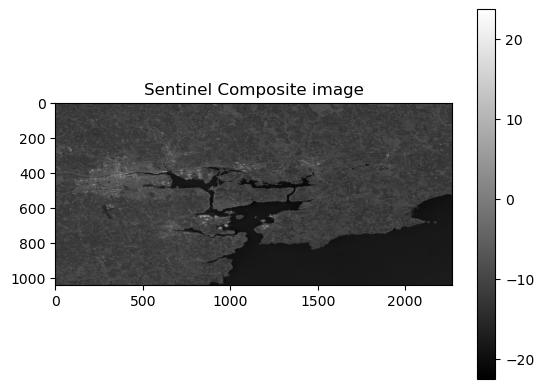

In [ ]:
# Importing the necessary libraries for reading and displaying the image.
# raterio to handle raster data, and maplotlib for visualizing it
import rasterio
from matplotlib import pyplot as plt

# Open the image from my desktop
with rasterio.open(r"C:\Users\Neo\Desktop\FYP\geeimages\Sentinel_Composite.tif") as src:
    # reading the image
    image = src.read(1)  # Read the first band

# Displaying the image using a grayscale colour map.
plt.imshow(image, cmap='gray')
plt.colorbar()
plt.title('Sentinel Composite image')
plt.show()



In [56]:
# Load and filter Sentinel-2 Image Collection (if not done in previous steps)
sentinel2_collection = ee.ImageCollection('COPERNICUS/S2') \
    .filterBounds(area_of_interest) \
    .filterDate(start_date, end_date) \
    .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 10))


In [57]:
# Function to calculate NDWI for a given image
def add_ndwi(image):
    ndwi = image.normalizedDifference(['B3', 'B8']).rename('NDWI')  # Calculate NDWI
    return image.addBands(ndwi)  # Add NDWI as a new band

# Map the function over the collection
ndwi_collection = sentinel2_collection.map(add_ndwi)


In [58]:
# Define threshold and create a binary water mask
def apply_ndwi_threshold(image):
    water_mask = image.select('NDWI').gt(0.3)  # Apply threshold
    return image.addBands(water_mask.rename('WaterMask'))  # Add mask as new band

# Apply the thresholding function to the collection
water_masked_collection = ndwi_collection.map(apply_ndwi_threshold)
